In [1]:
"""
introduce a validation fold for hyperparameter selection

Shaina Lu
Zador & Gillis Labs
March 2021
"""

'\nintroduce a validation fold for hyperparameter selection\n\nShaina Lu\nZador & Gillis Labs\nMarch 2021\n'

In [96]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV #stratify train/test split
from sklearn.metrics import make_scorer, roc_auc_score
import random

In [17]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# ST

### Read in Data and pre-processing

In [4]:
#infiles
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v1.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"

In [5]:
def read_data():
    """read in all datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')

    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return STspotsmeta, STspots, STpropont, ontology

__copied and pasted pre-processing functions__

In [6]:
def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score 
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain, copy=True)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain


def filterproponto(sampleonto):
    """pre-processing for propogated ontology for ST data"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    return leaves

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))
    #print feature_sort
    #print binarylabels_sort

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels) #- (len(binarylabels) - binarylabels.count())  #trying to subtract out 
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

# LASSO functions

In [7]:
def applyLASSO(Xtrain, Xtest, ytrain, ytest, alphaval):
    """apply LASSO regression"""
    lasso_reg = Lasso(alpha=alphaval, max_iter=10000)
    #lasso_reg = LinearRegression()
    lasso_reg.fit(Xtrain, ytrain)
    
    #train
    predictions_train = lasso_reg.predict(Xtrain)
    auroc_train = analytical_auroc(sp.stats.mstats.rankdata(predictions_train), ytrain)
    #test
    predictions_test = lasso_reg.predict(Xtest)
    auroc_test = analytical_auroc(sp.stats.mstats.rankdata(predictions_test), ytest)
    
    return auroc_train, auroc_test

In [8]:
def getallbyall(data, propont, alphaval):
    #initialize zeros dataframe to store entries
    allbyall_test = pd.DataFrame(index=list(propont), columns=list(propont))
    allbyall_test = allbyall_test.fillna(0)
    allbyall_train = pd.DataFrame(index=list(propont), columns=list(propont))
    allbyall_train = allbyall_train.fillna(0)
    
    areas = list(propont)
    #for each column, brain area
    for i in range(propont.shape[1]):
        print("col %d" %i)
        #for each row in each column
        for j in range(i+1,propont.shape[1]): #upper triangular!
            area1 = areas[i]
            area2 = areas[j]
            #get binary label vectors
            ylabels = propont.loc[propont[area1]+propont[area2] != 0, area1]
            #subset train and test sets for only samples in the two areas
            Xcurr = data.loc[propont[area1]+propont[area2] != 0, :]
            #split train test for X data and y labels
            Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.2,\
                                                            random_state=42, shuffle=True,\
                                                            stratify=ylabels)
            #further split for cross val

            #z-score current X data
            zXtrain = zscore(Xtrain)
            zXtest = zscore(Xtest)
            
            currauroc_train, currauroc_test = applyLASSO(zXtrain, zXtest, ytrain, ytest, alphaval)
            allbyall_train.iloc[i,j] = currauroc_train
            allbyall_test.iloc[i,j] = currauroc_test
            #curr_row[0,j] = currauroc
            
        #if i == 1:
        break
     
    #return temp
    return allbyall_train, allbyall_test

# Main

In [7]:
#pre-processing
STspotsmeta, STspots, STpropont, ontology = read_data()

In [8]:
STpropont = filterproponto(STpropont)

In [9]:
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
leafSTpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
leafSTspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

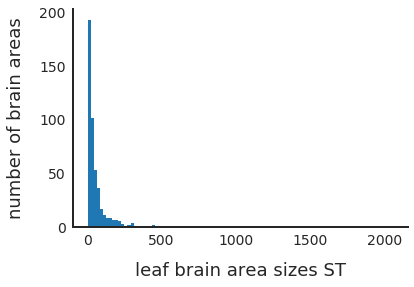

In [20]:
#determine brain areas with sufficient sample size that we'll use for hyperparameter selection
leafsizes = leafSTpropont.sum()
plt.hist(leafsizes, bins=100)
plt.xlabel("leaf brain area sizes ST")
plt.ylabel("number of brain areas")
plt.show()

In [49]:
#filter propogated ontology for brain areas with X number of samples min
leafsizes_sub = leafsizes[leafsizes>100]
leafSTpropont_sub = leafSTpropont.loc[:,leafsizes_sub.index]

In [63]:
#remove areas (rows) from propogated ontology that don't have any samples
rowsum = leafSTpropont_sub.sum(axis=1)
leafSTpropont_sub = leafSTpropont_sub.loc[rowsum > 0, :]

In [68]:
#index samples for rows to match porp ont
leafSTspots_sub = leafSTspots.loc[rowsum > 0, :]

In [ ]:
data = leafSTspots_sub
propont = leafSTpropont_sub

#initialize zeros dataframe to store entries
bestscore = pd.DataFrame(index=list(propont), columns=list(propont))
bestscore = bestscore.fillna(0)
bestparams = pd.DataFrame(index=list(propont), columns=list(propont))
bestparams = bestparams.fillna(0)
#meantestscore = pd.DataFrame(index=list(propont), columns=list(propont))
#meantestscore = meantestscore.fillna(0)

areas = list(propont)
#for each column, brain area
for i in range(propont.shape[1]):
    print("col %d" %i)
    #for each row in each column
    for j in range(i+1,propont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        ylabels = propont.loc[propont[area1]+propont[area2] != 0, area1]
        #subset train and test sets for only samples in the two areas
        Xcurr = data.loc[propont[area1]+propont[area2] != 0, :]
        
        #z-score moved to before split for CV
        zXcurr = zscore(Xcurr)
        
        #split train test for X data and y labels
        #Xtrain, Xtest, ytrain, ytest = train_test_split(Xcurr, ylabels, test_size=0.2,\
        #                                                random_state=42, shuffle=True,\
        #                                                stratify=ylabels)
        #further stratified splits for CV
        ssplits = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        ssplits.split(Xcurr,ylabels)
        
        #to actually get the folds
        #for train_index, test_index in ssplits.split(Xcurr, ylabels):
        #    #print("TRAIN:", train_index, "TEST:", test_index)
        #    X_train, X_test = Xcurr.iloc[train_index], Xcurr.iloc[test_index]
        #    y_train, y_test = ylabels.iloc[train_index], ylabels.iloc[test_index]
        
        model = Lasso(max_iter=10000)
        alpha = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
        
        grid = dict(alpha=alpha)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, \
                                   cv=ssplits, scoring='roc_auc', error_score=-1)
        grid_result = grid_search.fit(zXcurr,ylabels)


        #z-score current X data
        #zXtrain = zscore(Xtrain)
        #zXtest = zscore(Xtest)

        bestscore.iloc[i,j] = grid_result.best_score_
        bestparams.iloc[i,j] = grid_result.best_params_['alpha']
        #currmeantestscore = grid_result.cv_results_['mean_test_score'].values
        #meantestscore.iloc[i,j] = currmeantestscore

    #if i == 1:
    #break

col 0


In [ ]:
bestscore.to_csv("bestscore.csv", sep=',', header=True, index=False)
bestparams.to_csv("bestparams.csv", sep=',', header=True, index=False)

In [150]:
print("done")

done


In [16]:
#predictability matrix using LASSO
allbyall_train, allbyall_test = getallbyall(leafSTspots_sub, leafSTpropont_sub)

col 0
